In [6]:
from src.config import *

In [7]:
dfSPY = pd.read_csv('SPYrenew.csv')

In [10]:
dfSPY

,Date,Adj Close,Close,High,Low,Open,Volume
0,2019-06-03,250.930267,274.570007,276.549988,273.089996,275.309998,96428000
1,2019-06-04,256.377045,280.529999,280.679993,276.619995,277.119995,77231900
2,2019-06-05,258.597900,282.959991,282.989990,280.320007,282.329987,71169700
3,2019-06-06,260.279419,284.799988,285.549988,282.570007,283.290009,69430400
4,2019-06-07,262.884033,287.649994,288.850006,285.739990,285.929993,74272200
...,...,...,...,...,...,...,...
1406,2025-01-02,584.640015,584.640015,591.130005,580.500000,589.390015,50204000
1407,2025-01-03,591.950012,591.950012,592.599976,586.429993,587.530029,37888500
1408,2025-01-06,595.359985,595.359985,599.700012,593.599976,596.270020,47679400
1409,2025-01-07,588.630005,588.630005,597.750000,586.780029,597.419983,60393100


In [16]:
dfSPY.index = pd.to_datetime(dfSPY['Date'])

In [18]:
dfSPY.index

DatetimeIndex(['2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06',
               '2019-06-07', '2019-06-10', '2019-06-11', '2019-06-12',
               '2019-06-13', '2019-06-14',
               ...
               '2024-12-24', '2024-12-26', '2024-12-27', '2024-12-30',
               '2024-12-31', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08'],
              dtype='datetime64[ns]', name='Date', length=1411, freq=None)

In [25]:
def create_features(frame):
    df = frame.copy()
     
 
    df['CO'] = df['Close'] / df['Open'] 
    df['HC'] = df['High'] / df['Low']
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1))

    for j in [1,2,3,4,5,6,7]:
        df['Lagret' + str(j)] = df['RET'].shift(j)


    for i in [5, 10, 20, 65]:
        df['PCHG' + str(i)] = df['Close'].pct_change(i)   
        
        df['MA' + str(i)] = df['Close'].rolling(i).mean()
        df['EMA' + str(i)] = df['Close'].ewm(i, adjust = False).mean()
        
        df['RET' + str(i)] = df['RET'].rolling(i).mean()
        df['STD'+ str(i)] = df['RET'].rolling(i).std()


    df['UBol'] = df['Close'].rolling(20).mean() + df['Close'].rolling(20).std() * 2
    df['LBol'] = df['Close'].rolling(20).mean() - df['Close'].rolling(20).std() * 2

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['MACD'] = df['Close'].ewm(12).mean() - df['Close'].ewm(26).mean()
    df['MACD_signal'] = df['MACD'].ewm(9).mean()

    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))
    
    df['true_range'] = np.maximum(high_low, high_close, low_close)
    df['ATR14'] = df['true_range'].rolling(14).mean()
    
    df['Predict'] = df['Close'].shift(-1)
    df['label'] = np.where(df['Predict'] > 1.0025 *df['Close'], 1, 0)

    df.dropna(inplace=True)

    return df    

In [27]:
df1 = create_features(dfSPY)

In [29]:
df1

,Date,Adj Close,Close,High,Low,Open,Volume,CO,HC,RET,...,STD65,UBol,LBol,RSI,MACD,MACD_signal,true_range,ATR14,Predict,label
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-04,2019-09-04,270.030884,294.040009,294.059998,292.309998,293.140015,46887300,1.003070,1.005987,0.011286,...,0.009914,296.081980,283.606017,64.177869,-0.951063,-0.731009,3.320007,3.840709,297.820007,1
2019-09-05,2019-09-05,273.502289,297.820007,298.829987,294.000000,296.790009,83258100,1.003470,1.016429,0.012773,...,0.009690,297.445984,283.227014,66.976038,-0.670528,-0.724956,4.829987,3.953565,298.049988,0
2019-09-06,2019-09-06,273.713501,298.049988,298.760010,297.420013,298.170013,49584300,0.999597,1.004505,0.000772,...,0.009641,298.342234,282.773764,63.210781,-0.410943,-0.693530,1.339996,3.714994,298.200012,0
2019-09-09,2019-09-09,273.851227,298.200012,299.239990,297.160004,299.140015,51260300,0.996858,1.007000,0.000503,...,0.009614,299.383819,282.390180,59.320454,-0.173650,-0.641506,2.079987,3.561423,298.130005,0
2019-09-10,2019-09-10,273.786987,298.130005,298.200012,295.970001,297.359985,57947100,1.002590,1.007535,-0.000235,...,0.009544,300.362427,282.417571,63.710775,0.034976,-0.573816,2.230011,3.548569,300.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,2024-12-31,586.080017,586.080017,590.640015,584.419983,589.909973,57052700,0.993508,1.010643,-0.003645,...,0.007833,615.501066,583.575930,36.446209,5.151045,7.667777,6.220032,7.171430,584.640015,0
2025-01-02,2025-01-02,584.640015,584.640015,591.130005,580.500000,589.390015,50204000,0.991941,1.018312,-0.002460,...,0.007828,615.709793,581.440207,30.482382,4.512465,7.352246,10.630005,7.528573,591.950012,1
2025-01-03,2025-01-03,591.950012,591.950012,592.599976,586.429993,587.530029,37888500,1.007523,1.010521,0.012426,...,0.007881,614.608157,580.970847,40.118134,4.223549,7.039376,7.959961,7.895002,595.359985,1


In [32]:
print(df1.columns)

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CO',
       'HC', 'RET', 'Lagret1', 'Lagret2', 'Lagret3', 'Lagret4', 'Lagret5',
       'Lagret6', 'Lagret7', 'PCHG5', 'MA5', 'EMA5', 'RET5', 'STD5', 'PCHG10',
       'MA10', 'EMA10', 'RET10', 'STD10', 'PCHG20', 'MA20', 'EMA20', 'RET20',
       'STD20', 'PCHG65', 'MA65', 'EMA65', 'RET65', 'STD65', 'UBol', 'LBol',
       'RSI', 'MACD', 'MACD_signal', 'true_range', 'ATR14', 'Predict',
       'label'],
      dtype='object')


In [34]:
df1.index

DatetimeIndex(['2019-09-04', '2019-09-05', '2019-09-06', '2019-09-09',
               '2019-09-10', '2019-09-11', '2019-09-12', '2019-09-13',
               '2019-09-16', '2019-09-17',
               ...
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31', '2025-01-02', '2025-01-03',
               '2025-01-06', '2025-01-07'],
              dtype='datetime64[ns]', name='Date', length=1345, freq=None)

In [40]:
start = '2020-01-08'
end = '2025-01-03'

In [42]:
df2 = df1.loc[start: end]

In [44]:
df2

,Date,Adj Close,Close,High,Low,Open,Volume,CO,HC,RET,...,STD65,UBol,LBol,RSI,MACD,MACD_signal,true_range,ATR14,Predict,label
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08,2020-01-08,300.805542,324.450012,325.779999,322.670013,322.940002,68296000,1.004676,1.009638,0.005315,...,0.004976,326.714846,314.483158,65.561247,5.317640,4.949539,3.109985,1.958577,326.649994,1
2020-01-09,2020-01-09,302.845215,326.649994,326.730011,325.519989,326.160004,48473300,1.001502,1.003717,0.006758,...,0.004963,326.980362,315.529641,69.764847,5.408741,4.995459,2.279999,2.070005,325.709991,0
2020-01-10,2020-01-10,301.973724,325.709991,327.459991,325.200012,327.290009,53029300,0.995172,1.006950,-0.002882,...,0.004498,326.897016,316.741985,63.750715,5.436911,5.039604,2.259979,2.127145,327.950012,1
2020-01-13,2020-01-13,304.050446,327.950012,327.959991,325.920013,326.390015,47086800,1.004780,1.006259,0.006854,...,0.004440,327.636039,317.084963,68.456009,5.535572,5.089201,2.250000,2.103574,327.450012,0
2020-01-14,2020-01-14,303.586914,327.450012,328.619995,326.839996,327.470001,62832800,0.999939,1.005446,-0.001526,...,0.004416,328.049246,317.684757,65.917218,5.587601,5.139041,1.779999,2.165004,328.190002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,2024-12-27,595.010010,595.010010,597.780029,590.760010,597.539978,64969300,0.995766,1.011883,-0.010582,...,0.007686,614.713212,587.551784,38.919692,6.390685,8.187313,7.020020,6.735709,588.219971,0
2024-12-30,2024-12-30,588.219971,588.219971,591.739990,584.409973,587.890015,56578800,1.000561,1.012543,-0.011477,...,0.007820,615.145321,585.686674,36.600461,5.788323,7.947414,7.330017,6.989284,586.080017,0
2024-12-31,2024-12-31,586.080017,586.080017,590.640015,584.419983,589.909973,57052700,0.993508,1.010643,-0.003645,...,0.007833,615.501066,583.575930,36.446209,5.151045,7.667777,6.220032,7.171430,584.640015,0


In [93]:
dfx =  df2.drop(['Date','Open', 'High', 'Low', 'Close','Adj Close', 'Volume', 'Predict', 'label'], axis=1)

In [95]:
dfx

,CO,HC,RET,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,...,EMA65,RET65,STD65,UBol,LBol,RSI,MACD,MACD_signal,true_range,ATR14
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08,1.004676,1.009638,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,...,303.961628,0.001498,0.004976,326.714846,314.483158,65.561247,5.317640,4.949539,3.109985,1.958577
2020-01-09,1.001502,1.003717,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,...,304.305391,0.001668,0.004963,326.980362,315.529641,69.764847,5.408741,4.995459,2.279999,2.070005
2020-01-10,0.995172,1.006950,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,...,304.629703,0.001865,0.004498,326.897016,316.741985,63.750715,5.436911,5.039604,2.259979,2.127145
2020-01-13,1.004780,1.006259,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,...,304.983041,0.001825,0.004440,327.636039,317.084963,68.456009,5.535572,5.089201,2.250000,2.103574
2020-01-14,0.999939,1.005446,-0.001526,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,...,305.323450,0.001698,0.004416,328.049246,317.684757,65.917218,5.587601,5.139041,1.779999,2.165004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,...,570.640274,0.000660,0.007686,614.713212,587.551784,38.919692,6.390685,8.187313,7.020020,6.735709
2024-12-30,1.000561,1.012543,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,...,570.906633,0.000422,0.007820,615.145321,585.686674,36.600461,5.788323,7.947414,7.330017,6.989284
2024-12-31,0.993508,1.010643,-0.003645,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,...,571.136533,0.000388,0.007833,615.501066,583.575930,36.446209,5.151045,7.667777,6.220032,7.171430


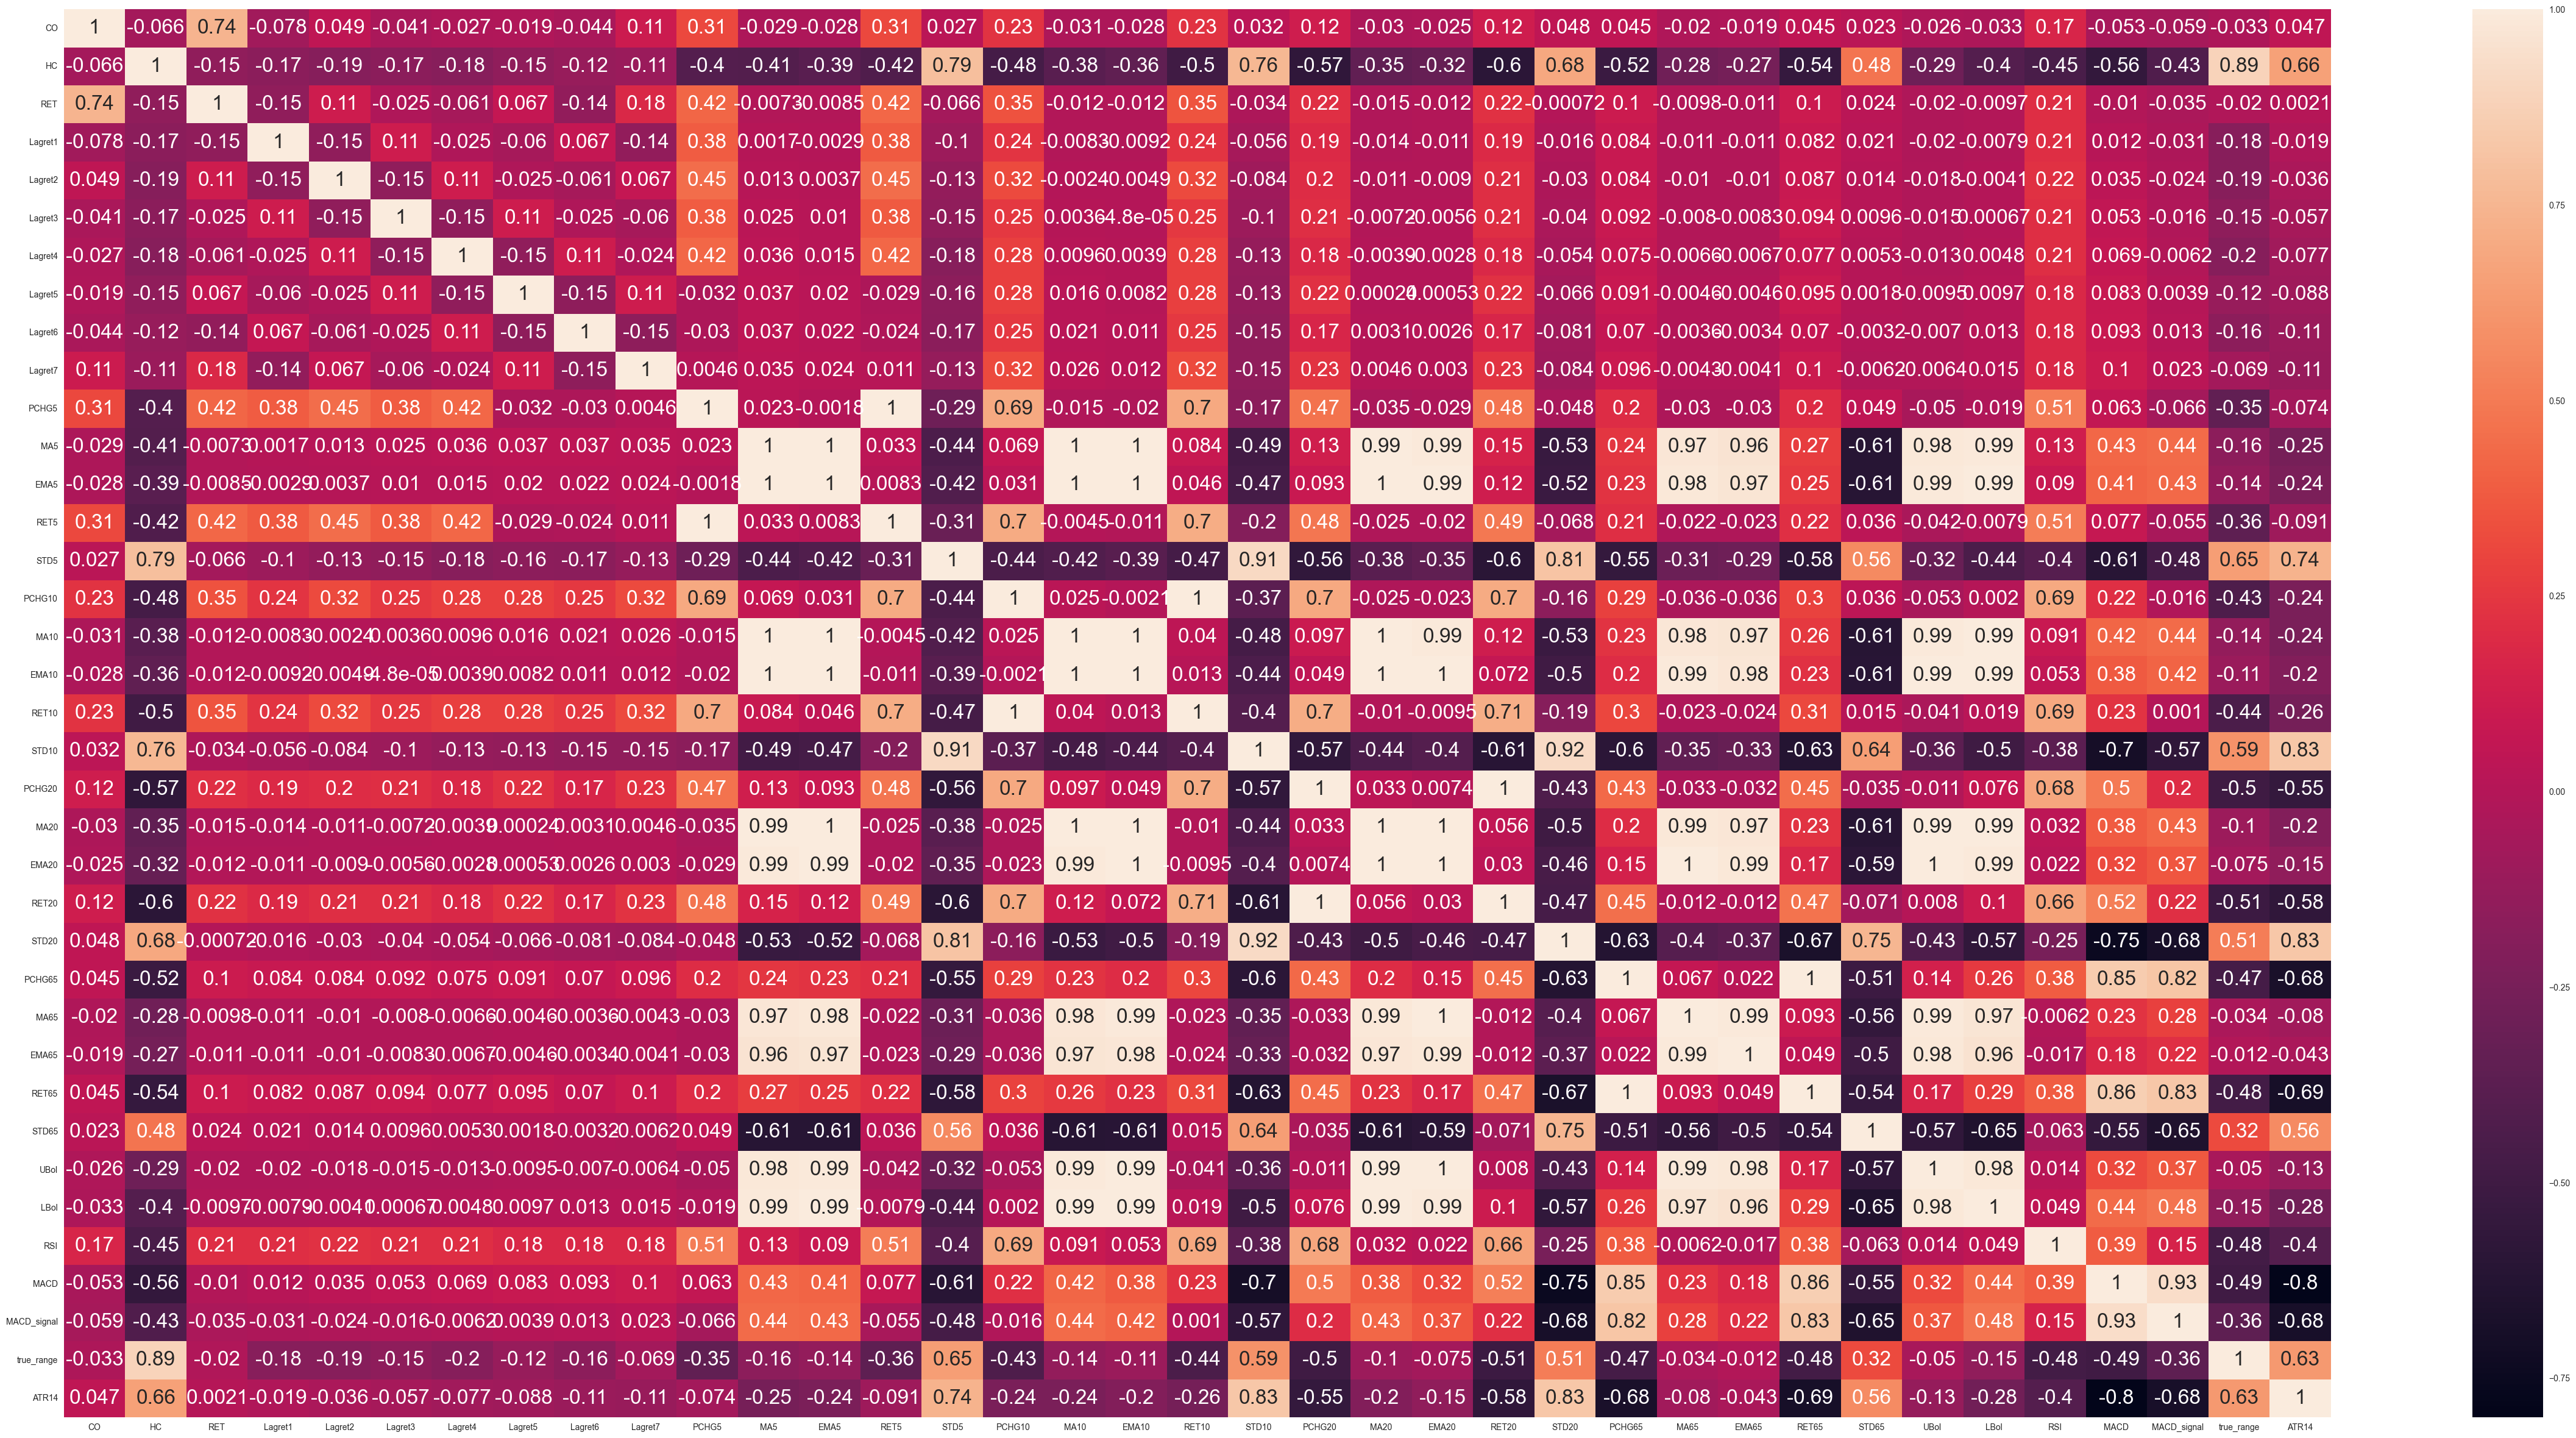

In [101]:
plt.figure(figsize=(60,30)) 

corr_matrix = dfx.corr()

sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 24})
plt.show()

In [102]:
def correlatedFeatures(data, threshold=0.6):
    colCorr = set()
    corrMatrix = dfx.corr()                  
    for i in range(len(corrMatrix.columns)):
            for j in range(i):
                if abs(corrMatrix.iloc[i, j]) > threshold:

                    colname = corrMatrix.columns[i]
                    colCorr.add(colname)

    return colCorr

In [105]:
correlated = correlatedFeatures(dfx, threshold=0.6)
print(correlated)

{'EMA10', 'UBol', 'EMA65', 'STD10', 'MACD', 'STD20', 'true_range', 'EMA20', 'STD65', 'MACD_signal', 'ATR14', 'STD5', 'PCHG20', 'RSI', 'MA20', 'RET65', 'RET', 'RET10', 'PCHG10', 'MA65', 'RET20', 'RET5', 'LBol', 'PCHG65', 'MA10', 'EMA5'}


In [107]:
dfx.drop(correlated, axis=1,inplace=True)

In [109]:
dfx

,CO,HC,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,PCHG5,MA5
Date,,,,,,,,,,,
2020-01-08,1.004676,1.009638,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,0.008047,323.620007
2020-01-09,1.001502,1.003717,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,0.005479,323.976007
2020-01-10,0.995172,1.006950,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,0.010235,324.636005
2020-01-13,1.004780,1.006259,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.013317,325.498004
2020-01-14,0.999939,1.005446,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.014625,326.442004
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,0.015202,596.698010
2024-12-30,1.000561,1.012543,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004957,596.112000
2024-12-31,0.993508,1.010643,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.014478,594.390002


In [113]:
dfx.to_csv('11features_renew.csv')

In [52]:
y = df2['label']

In [54]:
y.value_counts()

label
0    729
1    527
Name: count, dtype: int64

In [69]:
c = y.value_counts()

In [71]:
c

label
0    729
1    527
Name: count, dtype: int64

In [73]:
c0 = c[0]

In [75]:
c1 = c[1]

In [77]:
c0

729

In [79]:
c1

527

In [81]:
def cwts(data):
    c0, c1 = np.bincount(data)
    w0=(1/c0)*(len(data))/2 
    w1=(1/c1)*(len(data))/2 
    return {0: w0, 1: w1}

In [83]:
class_weight = cwts(y)
class_weight

{0: 0.8614540466392318, 1: 1.191650853889943}

In [85]:
class_weight[0] * c[0], class_weight[1] * c[1]

(628.0, 628.0)

In [116]:
dfyield = pd.read_csv('DGS10renew.csv')

In [118]:
dfyield

,observation_date,DGS10
0,2019-12-02,1.83
1,2019-12-03,1.72
2,2019-12-04,1.77
3,2019-12-05,1.80
4,2019-12-06,1.84
...,...,...
1327,2025-01-01,NaN
1328,2025-01-02,4.57
1329,2025-01-03,4.60
1330,2025-01-06,4.62


In [126]:
dfyield.columns = ['Date', 'DGS10']

In [128]:
print(dfyield.columns)

Index(['Date', 'DGS10'], dtype='object')


In [132]:
dfyield.index = pd.to_datetime(dfyield['Date'])

In [134]:
dfyield.index

DatetimeIndex(['2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13',
               ...
               '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-30',
               '2024-12-31', '2025-01-01', '2025-01-02', '2025-01-03',
               '2025-01-06', '2025-01-07'],
              dtype='datetime64[ns]', name='Date', length=1332, freq=None)

In [142]:
dfyield =  dfyield.drop(['Date'], axis=1)

In [173]:
dfyield

,DGS10
Date,
2019-12-02,1.83
2019-12-03,1.72
2019-12-04,1.77
2019-12-05,1.80
2019-12-06,1.84
...,...
2025-01-01,NaN
2025-01-02,4.57
2025-01-03,4.60


In [175]:
dfyield.isnull().sum()

DGS10    56
dtype: int64

In [180]:
def fill_missing(df):
    df['DGS10'] = df['DGS10'].interpolate(method='time').round(2)
    return df

In [182]:
dfyieldFillin = fill_missing(dfyield)

In [184]:
dfyieldFillin.isnull().sum()

DGS10    0
dtype: int64

In [186]:
dfyieldFillin['DGS10diff'] = dfyieldFillin['DGS10'] - dfyieldFillin['DGS10'].shift(1)

In [188]:
dfyieldFillin

,DGS10,DGS10diff
Date,,
2019-12-02,1.83,NaN
2019-12-03,1.72,-0.11
2019-12-04,1.77,0.05
2019-12-05,1.80,0.03
2019-12-06,1.84,0.04
...,...,...
2025-01-01,4.58,0.00
2025-01-02,4.57,-0.01
2025-01-03,4.60,0.03


In [190]:
dfyield_filtered = dfyieldFillin.loc[start:end]

In [192]:
dfyield_filtered

,DGS10,DGS10diff
Date,,
2020-01-08,1.87,0.04
2020-01-09,1.85,-0.02
2020-01-10,1.83,-0.02
2020-01-13,1.85,0.02
2020-01-14,1.82,-0.03
...,...,...
2024-12-30,4.55,-0.07
2024-12-31,4.58,0.03
2025-01-01,4.58,0.00


In [194]:
dfx_dates = dfx.index

In [196]:
dfyield_filtered = dfyield_filtered.reindex(dfx_dates)

In [198]:
dfx02 = pd.concat([dfx, dfyield_filtered], axis=1)

In [200]:
dfx02

,CO,HC,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,PCHG5,MA5,DGS10,DGS10diff
Date,,,,,,,,,,,,,
2020-01-08,1.004676,1.009638,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,0.008047,323.620007,1.87,0.04
2020-01-09,1.001502,1.003717,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,0.005479,323.976007,1.85,-0.02
2020-01-10,0.995172,1.006950,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,0.010235,324.636005,1.83,-0.02
2020-01-13,1.004780,1.006259,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.013317,325.498004,1.85,0.02
2020-01-14,0.999939,1.005446,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.014625,326.442004,1.82,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,0.015202,596.698010,4.62,0.04
2024-12-30,1.000561,1.012543,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004957,596.112000,4.55,-0.07
2024-12-31,0.993508,1.010643,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.014478,594.390002,4.58,0.03


In [202]:
dfx02.isnull().sum()

CO           0
HC           0
Lagret1      0
Lagret2      0
Lagret3      0
Lagret4      0
Lagret5      0
Lagret6      0
Lagret7      0
PCHG5        0
MA5          0
DGS10        0
DGS10diff    0
dtype: int64

In [204]:
dfinfla = pd.read_csv('T5YIFRrenew.csv')

In [206]:
dfinfla

,observation_date,T5YIFR
0,2019-12-02,1.76
1,2019-12-03,1.75
2,2019-12-04,1.78
3,2019-12-05,1.79
4,2019-12-06,1.79
...,...,...
1329,2025-01-03,2.28
1330,2025-01-06,2.28
1331,2025-01-07,2.32
1332,2025-01-08,2.33


In [208]:
dfinfla.columns = ['Date', 'T5YIFR']

In [210]:
print(dfinfla.columns)

Index(['Date', 'T5YIFR'], dtype='object')


In [212]:
dfinfla.index = pd.to_datetime(dfinfla['Date'])

In [214]:
dfinfla.index

DatetimeIndex(['2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13',
               ...
               '2024-12-27', '2024-12-30', '2024-12-31', '2025-01-01',
               '2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09'],
              dtype='datetime64[ns]', name='Date', length=1334, freq=None)

In [216]:
dfinfla

,Date,T5YIFR
Date,,
2019-12-02,2019-12-02,1.76
2019-12-03,2019-12-03,1.75
2019-12-04,2019-12-04,1.78
2019-12-05,2019-12-05,1.79
2019-12-06,2019-12-06,1.79
...,...,...
2025-01-03,2025-01-03,2.28
2025-01-06,2025-01-06,2.28
2025-01-07,2025-01-07,2.32


In [224]:
dfinfla =  dfinfla.drop(['Date'], axis=1)

In [220]:
dfinfla.isnull().sum()

T5YIFR    56
dtype: int64

In [226]:
def fill_missing(df):
    df['T5YIFR'] = df['T5YIFR'].interpolate(method='time').round(2)
    return df

In [228]:
dfinflaFillin = fill_missing(dfinfla)

In [230]:
dfinflaFillin.isnull().sum()

T5YIFR    0
dtype: int64

In [232]:
dfinfla_filtered = dfinflaFillin.loc[start:end]

In [234]:
dfinfla_filtered = dfinfla_filtered.reindex(dfx_dates)

In [236]:
dfx03 = pd.concat([dfx02, dfinfla_filtered], axis=1)

In [238]:
dfx03

,CO,HC,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,PCHG5,MA5,DGS10,DGS10diff,T5YIFR
Date,,,,,,,,,,,,,,
2020-01-08,1.004676,1.009638,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,0.008047,323.620007,1.87,0.04,1.82
2020-01-09,1.001502,1.003717,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,0.005479,323.976007,1.85,-0.02,1.81
2020-01-10,0.995172,1.006950,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,0.010235,324.636005,1.83,-0.02,1.85
2020-01-13,1.004780,1.006259,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.013317,325.498004,1.85,0.02,1.84
2020-01-14,0.999939,1.005446,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.014625,326.442004,1.82,-0.03,1.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,0.015202,596.698010,4.62,0.04,2.30
2024-12-30,1.000561,1.012543,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004957,596.112000,4.55,-0.07,2.27
2024-12-31,0.993508,1.010643,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.014478,594.390002,4.58,0.03,2.30


In [240]:
dfx03.isnull().sum()

CO           0
HC           0
Lagret1      0
Lagret2      0
Lagret3      0
Lagret4      0
Lagret5      0
Lagret6      0
Lagret7      0
PCHG5        0
MA5          0
DGS10        0
DGS10diff    0
T5YIFR       0
dtype: int64

In [243]:
dfVIX = pd.read_csv('VIXrenew.csv')

In [245]:
dfVIX

,Date,Close_VIX
0,2020-01-02,12.470000
1,2020-01-03,14.020000
2,2020-01-06,13.850000
3,2020-01-07,13.790000
4,2020-01-08,13.450000
...,...,...
1258,2025-01-02,17.930000
1259,2025-01-03,16.129999
1260,2025-01-06,16.040001
1261,2025-01-07,17.820000


In [248]:
dfVIX.index = pd.to_datetime(dfVIX['Date'])

In [250]:
dfVIX.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2024-12-24', '2024-12-26', '2024-12-27', '2024-12-30',
               '2024-12-31', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08'],
              dtype='datetime64[ns]', name='Date', length=1263, freq=None)

In [255]:
print(dfVIX.columns)

Index(['Date', 'Close_VIX'], dtype='object')


In [258]:
dfVIX =  dfVIX.drop(['Date'], axis=1)

In [260]:
dfVIX

,Close_VIX
Date,
2020-01-02,12.470000
2020-01-03,14.020000
2020-01-06,13.850000
2020-01-07,13.790000
2020-01-08,13.450000
...,...
2025-01-02,17.930000
2025-01-03,16.129999
2025-01-06,16.040001


In [263]:
dfVIX_filtered = dfVIX.loc[start:end]

In [266]:
dfx04 = dfx03.join(dfVIX_filtered,how='left')

In [268]:
dfx04

,CO,HC,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,PCHG5,MA5,DGS10,DGS10diff,T5YIFR,Close_VIX
Date,,,,,,,,,,,,,,,
2020-01-08,1.004676,1.009638,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,0.008047,323.620007,1.87,0.04,1.82,13.450000
2020-01-09,1.001502,1.003717,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,0.005479,323.976007,1.85,-0.02,1.81,12.540000
2020-01-10,0.995172,1.006950,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,0.010235,324.636005,1.83,-0.02,1.85,12.560000
2020-01-13,1.004780,1.006259,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.013317,325.498004,1.85,0.02,1.84,12.320000
2020-01-14,0.999939,1.005446,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.014625,326.442004,1.82,-0.03,1.84,12.390000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,0.015202,596.698010,4.62,0.04,2.30,15.950000
2024-12-30,1.000561,1.012543,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004957,596.112000,4.55,-0.07,2.27,17.400000
2024-12-31,0.993508,1.010643,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.014478,594.390002,4.58,0.03,2.30,17.350000


In [276]:
dfQQQ = pd.read_csv('QQQmerged.csv')

In [278]:
dfQQQ

,Date,Adj Close_QQQ,Close_QQQ,High_QQQ,Low_QQQ,Open_QQQ,Volume_QQQ,Close_QQQdiff,Residuals,Residuals_lag
0,2020-01-08,210.598206,217.149994,218.139999,215.160004,215.500000,26397300,1.619995,22.783946,22.626227
1,2020-01-09,212.382660,218.990005,219.410004,217.710007,218.940002,23547000,1.840012,23.209467,22.783946
2,2020-01-10,211.839584,218.429993,219.869995,218.039993,219.850006,21898500,-0.560013,22.809526,23.209467
3,2020-01-13,214.283539,220.949997,220.979996,218.979996,219.330002,22756900,2.520004,22.619318,22.809526
4,2020-01-14,213.439804,220.080002,221.210007,219.740005,220.839996,24418100,-0.869995,22.958320,22.619318
...,...,...,...,...,...,...,...,...,...,...
1251,2024-12-27,522.559998,522.559998,526.450012,517.859985,526.010010,33839600,-7.039978,-1.185772,-1.644932
1252,2024-12-30,515.609985,515.609985,519.359985,511.829987,515.510010,34584000,-6.950012,-1.273394,-1.185772
1253,2024-12-31,511.230011,511.230011,517.659973,510.260010,516.900024,29117000,-4.379974,0.810589,-1.273394
1254,2025-01-02,510.230011,510.230011,516.640015,505.709991,514.299988,36389800,-1.000000,0.334961,0.810589


In [280]:
dfQQQ.index = pd.to_datetime(dfQQQ['Date'])

In [282]:
dfQQQ.index

DatetimeIndex(['2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
               '2020-01-21', '2020-01-22',
               ...
               '2024-12-19', '2024-12-20', '2024-12-23', '2024-12-24',
               '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31',
               '2025-01-02', '2025-01-03'],
              dtype='datetime64[ns]', name='Date', length=1256, freq=None)

In [285]:
print(dfQQQ.columns)

Index(['Date', 'Adj Close_QQQ', 'Close_QQQ', 'High_QQQ', 'Low_QQQ', 'Open_QQQ',
       'Volume_QQQ', 'Close_QQQdiff', 'Residuals', 'Residuals_lag'],
      dtype='object')


In [287]:
dfQQQ =  dfQQQ.drop(['Date', 'Adj Close_QQQ', 'Close_QQQ', 'High_QQQ', 'Low_QQQ', 'Open_QQQ','Volume_QQQ','Residuals'], axis=1)

In [289]:
dfQQQ

,Close_QQQdiff,Residuals_lag
Date,,
2020-01-08,1.619995,22.626227
2020-01-09,1.840012,22.783946
2020-01-10,-0.560013,23.209467
2020-01-13,2.520004,22.809526
2020-01-14,-0.869995,22.619318
...,...,...
2024-12-27,-7.039978,-1.644932
2024-12-30,-6.950012,-1.185772
2024-12-31,-4.379974,-1.273394


In [291]:
dfx05 = dfx04.join(dfQQQ,how='left')

In [294]:
dfx05

,CO,HC,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,PCHG5,MA5,DGS10,DGS10diff,T5YIFR,Close_VIX,Close_QQQdiff,Residuals_lag
Date,,,,,,,,,,,,,,,,,
2020-01-08,1.004676,1.009638,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,0.008047,323.620007,1.87,0.04,1.82,13.450000,1.619995,22.626227
2020-01-09,1.001502,1.003717,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,0.005479,323.976007,1.85,-0.02,1.81,12.540000,1.840012,22.783946
2020-01-10,0.995172,1.006950,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,0.010235,324.636005,1.83,-0.02,1.85,12.560000,-0.560013,23.209467
2020-01-13,1.004780,1.006259,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.013317,325.498004,1.85,0.02,1.84,12.320000,2.520004,22.809526
2020-01-14,0.999939,1.005446,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.014625,326.442004,1.82,-0.03,1.84,12.390000,-0.869995,22.619318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,0.015202,596.698010,4.62,0.04,2.30,15.950000,-7.039978,-1.644932
2024-12-30,1.000561,1.012543,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004957,596.112000,4.55,-0.07,2.27,17.400000,-6.950012,-1.185772
2024-12-31,0.993508,1.010643,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.014478,594.390002,4.58,0.03,2.30,17.350000,-4.379974,-1.273394


In [296]:
dfDIA = pd.read_csv('DIAmerged.csv')

In [298]:
dfDIA

,Date,Adj Close_DIA,Close_DIA,High_DIA,Low_DIA,Open_DIA,Volume_DIA,Close_DIAdiff,Residuals,Residuals_lag
0,2020-01-08,260.887421,287.399994,288.670013,285.079987,285.320007,3136700,1.660004,-21.174232,-20.217192
1,2020-01-09,262.848236,289.559998,289.839996,288.429993,288.950012,1783100,2.160004,-22.457627,-21.174232
2,2020-01-10,261.649902,288.239990,290.040009,287.839996,289.959991,2989600,-1.320007,-21.268891,-22.457627
3,2020-01-13,262.357971,289.019989,289.079987,288.140015,288.790009,1463300,0.779999,-20.286752,-21.268891
4,2020-01-14,262.539490,289.220001,290.489990,288.720001,288.869995,2198500,0.200012,-21.109306,-20.286752
...,...,...,...,...,...,...,...,...,...,...
1251,2024-12-27,430.000000,430.000000,432.290009,427.429993,430.579987,2429100,-3.209991,19.418763,20.572117
1252,2024-12-30,425.769989,425.769989,427.660004,422.519989,425.470001,3858300,-4.230011,19.450343,19.418763
1253,2024-12-31,425.500000,425.500000,427.739990,424.040009,426.910004,2442700,-0.269989,17.745793,19.450343
1254,2025-01-02,423.799988,423.799988,428.959991,421.589996,428.339996,4231500,-1.700012,19.047352,17.745793


In [302]:
dfDIA.index = pd.to_datetime(dfDIA['Date'])

In [304]:
dfDIA.index

DatetimeIndex(['2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
               '2020-01-21', '2020-01-22',
               ...
               '2024-12-19', '2024-12-20', '2024-12-23', '2024-12-24',
               '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31',
               '2025-01-02', '2025-01-03'],
              dtype='datetime64[ns]', name='Date', length=1256, freq=None)

In [306]:
print(dfDIA.columns)

Index(['Date', 'Adj Close_DIA', 'Close_DIA', 'High_DIA', 'Low_DIA', 'Open_DIA',
       'Volume_DIA', 'Close_DIAdiff', 'Residuals', 'Residuals_lag'],
      dtype='object')


In [308]:
dfDIA =  dfDIA.drop(['Date', 'Adj Close_DIA', 'Close_DIA', 'High_DIA', 'Low_DIA', 'Open_DIA','Volume_DIA','Residuals'], axis=1)

In [310]:
dfDIA

,Close_DIAdiff,Residuals_lag
Date,,
2020-01-08,1.660004,-20.217192
2020-01-09,2.160004,-21.174232
2020-01-10,-1.320007,-22.457627
2020-01-13,0.779999,-21.268891
2020-01-14,0.200012,-20.286752
...,...,...
2024-12-27,-3.209991,20.572117
2024-12-30,-4.230011,19.418763
2024-12-31,-0.269989,19.450343


In [316]:
dfDIA = dfDIA.rename(columns={'Residuals_lag': 'ResidualsDIA_lag'})

In [318]:
dfx06 = dfx05.join(dfDIA,how='left')

In [320]:
dfx06

,CO,HC,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,PCHG5,MA5,DGS10,DGS10diff,T5YIFR,Close_VIX,Close_QQQdiff,Residuals_lag,Close_DIAdiff,ResidualsDIA_lag
Date,,,,,,,,,,,,,,,,,,,
2020-01-08,1.004676,1.009638,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,0.008047,323.620007,1.87,0.04,1.82,13.450000,1.619995,22.626227,1.660004,-20.217192
2020-01-09,1.001502,1.003717,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,0.005479,323.976007,1.85,-0.02,1.81,12.540000,1.840012,22.783946,2.160004,-21.174232
2020-01-10,0.995172,1.006950,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,0.010235,324.636005,1.83,-0.02,1.85,12.560000,-0.560013,23.209467,-1.320007,-22.457627
2020-01-13,1.004780,1.006259,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.013317,325.498004,1.85,0.02,1.84,12.320000,2.520004,22.809526,0.779999,-21.268891
2020-01-14,0.999939,1.005446,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.014625,326.442004,1.82,-0.03,1.84,12.390000,-0.869995,22.619318,0.200012,-20.286752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,0.015202,596.698010,4.62,0.04,2.30,15.950000,-7.039978,-1.644932,-3.209991,20.572117
2024-12-30,1.000561,1.012543,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004957,596.112000,4.55,-0.07,2.27,17.400000,-6.950012,-1.185772,-4.230011,19.418763
2024-12-31,0.993508,1.010643,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.014478,594.390002,4.58,0.03,2.30,17.350000,-4.379974,-1.273394,-0.269989,19.450343


In [322]:
dfx06 = dfx06.rename(columns={'Residuals_lag': 'ResidualsQQQ_lag'})

In [325]:
dfx06 = dfx06.drop(['DGS10'], axis=1)

In [327]:
dfx06

,CO,HC,Lagret1,Lagret2,Lagret3,Lagret4,Lagret5,Lagret6,Lagret7,PCHG5,MA5,DGS10diff,T5YIFR,Close_VIX,Close_QQQdiff,ResidualsQQQ_lag,Close_DIAdiff,ResidualsDIA_lag
Date,,,,,,,,,,,,,,,,,,
2020-01-08,1.004676,1.009638,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,-0.000248,0.008047,323.620007,0.04,1.82,13.450000,1.619995,22.626227,1.660004,-20.217192
2020-01-09,1.001502,1.003717,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,-0.005528,0.005479,323.976007,-0.02,1.81,12.540000,1.840012,22.783946,2.160004,-21.174232
2020-01-10,0.995172,1.006950,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.002426,0.010235,324.636005,-0.02,1.85,12.560000,-0.560013,23.209467,-1.320007,-22.457627
2020-01-13,1.004780,1.006259,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.009308,0.013317,325.498004,0.02,1.84,12.320000,2.520004,22.809526,0.779999,-21.268891
2020-01-14,0.999939,1.005446,0.006854,-0.002882,0.006758,0.005315,-0.002816,0.003808,-0.007601,0.014625,326.442004,-0.03,1.84,12.390000,-0.869995,22.619318,0.200012,-20.286752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.995766,1.011883,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004129,0.015202,596.698010,0.04,2.30,15.950000,-7.039978,-1.644932,-3.209991,20.572117
2024-12-30,1.000561,1.012543,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.030257,-0.004957,596.112000,-0.07,2.27,17.400000,-6.950012,-1.185772,-4.230011,19.418763
2024-12-31,0.993508,1.010643,-0.011477,-0.010582,0.000067,0.011054,0.005970,0.008579,-0.000307,-0.014478,594.390002,0.03,2.30,17.350000,-4.379974,-1.273394,-0.269989,19.450343
